### Short-Term Momentum Effect

We investigate the effects of specific series of corporate financial news events and their effects on associated asset returns.
Financial news of company XY, that are published during market closing hours (4pm to 9:30am), tend to be followed by positive (negative) average next-day returns if the news are classified as positive (negative).     
  
We observe that this effect is amplified if the market shows a strong reaction to those news events. A negative news article that is occompanied with a sharp price drop on the same day receives more investor attention than a negative sounding news article without a significant price drop. The data shows that the release of another negative news article later in the evening during market closing hours lowers the likelihood of a possible reversal on the following trading day in favor of a further drop in prices due to the growing fear of a continuing sell-off. 

**Null Hypothesis H0**    
Asset returns show no predictability on day t=t1 based on information contained in financial news that is available on day t=t1. Thus, the mean return on day t=t2 = 0.

**Hypothesis H1**  
Negative company news released on day t=1 that go hand-in-hand with significantely neagative returns on day t=1 tend to be followed by negative returns on day t=2.

**Hypothesis H2**  
A 2-day series of negative company news released on day t=t0 and t=t1, that go hand-in-hand with negative daily returns on day t=t0 and t=t1 tend to be followed by further negative returns on day t=t2 (and t=t3).

**Hypothesis H3**  
A 3-day series of negative news events from day t=t0 to t=t2 that goes hand-in-hand with declining prices shows an increased likelihood of a reversal on day t=t3.  

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from cycler import cycler
from scipy.stats import ttest_1samp

color_list = ["#348ABD","#A60628","#7A68A6","#467821","#CF4457","#188487","#E24A33"]
style = {
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.prop_cycle": cycler('color', color_list),
  "axes.facecolor": "#eeeeee",
  "axes.labelsize": "large",
  "axes.grid": True,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.fonttype": "path"}

matplotlib.rcParams.update(style)


def load_data(file):
    df = pd.read_csv(file, encoding='utf-8-sig')
    df.index = pd.to_datetime(df.Date)
    df = df.rename(columns={'Prediction value': 'prediction_value'})
    return df


def plot_events_chart(ticker_price_index, ticker_news, year):
    fix, ax = plt.subplots(figsize=(18,4))
    sns.lineplot(data=ticker_price_index, linewidth=1)

    for i in ticker_news.index:
        if ticker_news.loc[i, 'Prediction'] == 1:
            if ticker_news.loc[i, 'z_value_t'] <= -1.96:
                c = 'r'
            else:
                c = 'm'
        else:
            c = 'g'
        plt.axvline(ticker_news.Timestamp_ET[i], color=c, linestyle='--', linewidth=0.5)

    plt.xticks(rotation=45)
    plt.title(year)
    plt.show()

In [2]:
# Load the Data Frame (with either returns or abnormal returns!)
data_path = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Python/Data/"
extended_model_path = data_path+'Classification/DagoBERT/SCE_Loss_minw_25_lr_5e5_3ep_bs32_wd_1e2_a0_5_b3_NN1_w2v_topics/' 

df = load_data(extended_model_path+'train_valid_data_inkl_pred_and_returns_moo17_5h_z_val_timestamp_fresh_SCE_NN1_w2v_topics_'+str(2002)+'-'+str(2021)+'.csv')
df.head(2)

,Timestamp_ET,Ticker,Date,News,Sentiment,freshness,topic_1,topic_2,topic_3,topic_4,...,return_t_4,return_t_5,return_t_6,return_t_7,return_t_8,z_value_t_III,z_value_t_II,z_value_t_I,z_value_t,z_value_t_1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-07,2002-01-07 02:02:36.958,SIAL,2002-01-07,sia tightens security for valuable cargo singa...,0.0,fresh,0.0,0.0,0.0,0.0,...,0.007860,-0.001463,-0.001465,-0.015392,-0.019865,-0.390105,0.608330,1.161570,-0.233635,1.035706
2002-01-07,2002-01-07 03:30:49.975,CCL,2002-01-07,carnival in new offensive to win princess by s...,0.0,stale,0.0,0.0,0.0,0.0,...,0.021748,-0.023859,-0.016163,-0.008403,-0.001934,-0.818502,-0.870217,-0.227346,1.373560,-1.045061


##   
Calculate the mean of the predicted news sentiment (prediction_value) for each company, that appears in the news, on day t-2, t-1 and day t.
Also merge the predicted news sentiment with the z-value calcualted on day t, and with the associated asset return on day t-2, t-1, t and t+1.

In [13]:
dates = df.index.unique()

for i, date in enumerate(dates[:-2]):
    # day t-2
    df_slice_t_II = df.loc[dates[i], ['Ticker', 'prediction_value']]
    if df_slice_t_II.ndim == 1:
        df_slice_t_II = df_slice_t_II.to_frame().T
    df_slice_t_II.columns = ['Ticker', 'prediction_value_t_II']
    df_slice_t_II = df_slice_t_II.groupby('Ticker').mean()                  # Calculate the average sentiment of all news articles on day t-2

    # day t-1
    df_slice_t_I = df.loc[dates[i+1], ['Ticker', 'prediction_value']]
    if df_slice_t_I.ndim == 1:
        df_slice_t_I = df_slice_t_I.to_frame().T
    df_slice_t_I.columns = ['Ticker', 'prediction_value_t_I']
    df_slice_t_I = df_slice_t_I.groupby('Ticker').mean()

    # merge day-2 and day-1 dataframes
    df_slice_t_I_II = pd.merge(left=df_slice_t_I, right=df_slice_t_II, left_index=True, right_index=True, how='left')

    # day t
    df_slice_t = df.loc[dates[i+2], ['Ticker', 'prediction_value', 'z_value_t', 'return_t_II', 'return_t_I', 'return_t', 'return_t_1']]
    if df_slice_t.ndim == 1:
        df_slice_t = df_slice_t.to_frame().T
    df_slice_t = df_slice_t.groupby('Ticker').mean()

    df_slice = pd.merge(left=df_slice_t, right=df_slice_t_I_II, left_index=True, right_index=True, how='left')
    df_slice = df_slice.loc[:,['prediction_value_t_II', 'prediction_value_t_I', 'prediction_value', 'z_value_t', 'return_t_II', 'return_t_I', 'return_t', 'return_t_1']]

    if i == 0:
        pred_return_df = df_slice.copy()
    else:
        pred_return_df = pd.concat([pred_return_df, df_slice], axis=0)
        

print(pred_return_df.shape)
pred_return_df.head()

(122518, 8)


,prediction_value_t_II,prediction_value_t_I,prediction_value,z_value_t,return_t_II,return_t_I,return_t,return_t_1
Ticker,,,,,,,,
AAPL,0.003186,-0.006568,0.016002,-0.164556,0.016308,-0.040786,0.001846,-0.069263
BBY,NaN,NaN,0.493360,0.069826,-0.004293,0.011678,0.004052,-0.019587
CSCO,NaN,-0.987580,0.993905,0.979299,-0.008966,-0.019048,0.032039,-0.021636
DIS,0.008352,-0.981504,-0.486995,-1.114129,0.016992,-0.001634,-0.022381,-0.022537
DUK,NaN,NaN,0.016490,0.411370,0.009091,-0.021878,0.010527,0.022133


## 
Load returns from pred_return_df for different series of events.   
E.g.: Load the return for all events where there is a negative predicted news sentiment on day t-1 and on day t and the z_value on day t is also negative.

In [14]:
return_val    = 'return_t_1' # We consider the return from market open to market open on day t+1
z_val_barrier = -1.96
barrier       = 0.95         # predicted_sentiment >= barrier -> positive (long) | predicted_sentiment <= barrier -> negative (short)

plot_df = pd.DataFrame(columns=['3d_neg_z_return', '2d_neg_z_return', '1d_neg_z_return', '1d_neg_return', '2d_neg_return', '3d_neg_return', 
                                '3d_pos_return', '2d_pos_return', '1d_pos_return'])


# Positive/Negative news on day t ------------------------------------------------------------------------------------------
plot_df['1d_pos_return'] = pred_return_df.loc[(pred_return_df.prediction_value >=  barrier), return_val].reset_index(drop=True)
plot_df['1d_neg_return'] = pred_return_df.loc[(pred_return_df.prediction_value <= -barrier), return_val].reset_index(drop=True)


# Positive/Negative news on day t and on day t-1 ---------------------------------------------------------------------------
plot_df['2d_pos_return'] = pred_return_df.loc[(pred_return_df.prediction_value_t_I >= barrier)  & 
                                              (pred_return_df.prediction_value     >= barrier), return_val].reset_index(drop=True)

plot_df['2d_neg_return'] = pred_return_df.loc[(pred_return_df.prediction_value_t_I <= -barrier) & 
                                              (pred_return_df.prediction_value     <= -barrier), return_val].reset_index(drop=True)


# Positive/Negative news on day t, on day t-1 and on day t-2 ----------------------------------------------------------------
plot_df['3d_pos_return'] = pred_return_df.loc[(pred_return_df.prediction_value_t_II >= barrier)  & 
                                              (pred_return_df.prediction_value_t_I  >= barrier)  &
                                              (pred_return_df.prediction_value      >= barrier), return_val].reset_index(drop=True)

plot_df['3d_neg_return'] = pred_return_df.loc[(pred_return_df.prediction_value_t_II <= -barrier) & 
                                              (pred_return_df.prediction_value_t_I  <= -barrier) & 
                                              (pred_return_df.prediction_value      <= -barrier), return_val].reset_index(drop=True)


# Negative news on day t and significantely negative z-value on day t -------------------------------------------------------
plot_df['1d_neg_z_return'] = pred_return_df.loc[(pred_return_df.prediction_value <= -barrier)    &
                                                (pred_return_df.z_value_t        <=  z_val_barrier), return_val].reset_index(drop=True)


# Negative news on day t and on day t-1 and significantely negative z-value on day t ----------------------------------------
plot_df['2d_neg_z_return'] = pred_return_df.loc[(pred_return_df.prediction_value_t_I <= -barrier) & 
                                                (pred_return_df.prediction_value     <= -barrier) &
                                                (pred_return_df.z_value_t            <= z_val_barrier), return_val].reset_index(drop=True)



# Negative news on day t, on day t-1 and on day t-2 and significantely negative z-value on day t -----------------------------
plot_df['3d_neg_z_return'] = pred_return_df.loc[(pred_return_df.prediction_value_t_II <= -barrier) & 
                                                (pred_return_df.prediction_value_t_I  <= -barrier) & 
                                                (pred_return_df.prediction_value      <= -barrier) &
                                                (pred_return_df.z_value_t             <= z_val_barrier), return_val].reset_index(drop=True)


# Standard Normal Distribution
plot_df['std_norm'] = np.random.normal(loc=0, scale=0.3/np.sqrt(252), size=plot_df.shape[0])

plot_df.head(3)

,3d_neg_z_return,2d_neg_z_return,1d_neg_z_return,1d_neg_return,2d_neg_return,3d_neg_return,3d_pos_return,2d_pos_return,1d_pos_return,std_norm
0,0.007643,-0.036543,0.029185,0.002471,0.002650,-0.009982,0.015507,-0.011539,-0.021636,0.009207
1,-0.002837,0.030142,0.003729,0.015649,-0.009982,-0.025939,0.011683,-0.037226,-0.037226,-0.003596
2,-0.062877,-0.019102,0.026729,0.057399,-0.022972,-0.028539,0.008848,0.046635,-0.027780,0.010404


## 
Density plots of the return distributions

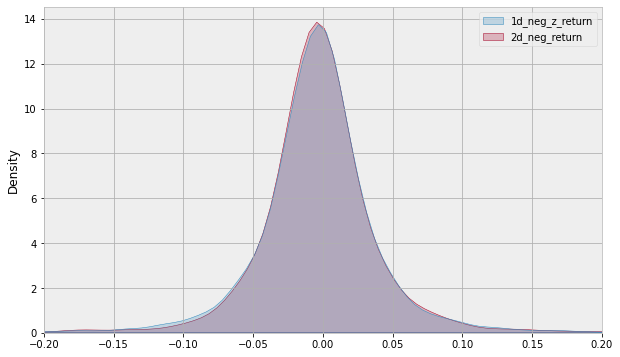

In [16]:
fix, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(data=plot_df[['1d_neg_z_return', '2d_neg_return']], common_norm=False, fill=True, cumulative=False)
plt.xlim(-0.2, 0.2)
plt.show()

## 
Descriptive Statistics

In [17]:
stats_df = pd.DataFrame(columns=plot_df.columns)
for x in stats_df:
    stats_df.loc['mean in %', x]      = round(plot_df[x].dropna().mean()*100,3)
    stats_df.loc['mean p.a.in %', x]  = round(plot_df[x].dropna().mean()*100*252,3)
    stats_df.loc['sd in %', x]        = round(plot_df[x].dropna().std()*100,3)
    stats_df.loc['sd p.a. in %', x]   = round(plot_df[x].dropna().std()*100*np.sqrt(252),3)
    stats_df.loc['t_val', x]   = ttest_1samp(plot_df[x].dropna(), 0)[0]
    stats_df.loc['p_val', x]   = ttest_1samp(plot_df[x].dropna(), 0)[1]
    stats_df.loc['support', x] = plot_df[x].dropna().shape[0]
    
stats_df

,3d_neg_z_return,2d_neg_z_return,1d_neg_z_return,1d_neg_return,2d_neg_return,3d_neg_return,3d_pos_return,2d_pos_return,1d_pos_return,std_norm
mean in %,1.049,-0.387,-0.306,-0.058,-0.218,0.531,0.213,0.164,0.135,0.009
mean p.a.in %,264.344,-97.615,-77.175,-14.698,-54.973,133.925,53.791,41.387,34.034,2.266
sd in %,10.697,4.938,4.679,4.223,4.96,8.223,2.256,2.765,3.194,1.893
sd p.a. in %,169.816,78.392,74.284,67.034,78.739,130.531,35.811,43.889,50.698,30.052
t_val,0.650455,-2.225563,-4.710732,-1.884829,-1.855026,0.812414,1.280002,2.773574,6.538651,0.734492
p_val,0.518859,0.02632,0.000003,0.059468,0.063758,0.417784,0.202174,0.005592,0.0,0.462656
support,44,805,5181,18622,1779,158,183,2180,23907,23913
